4. (1 point) Using the previous functions, obtain:
(a) A graph of related artists starting with the artist Drake and exploring 200 artists with BFS (we will call this graph gB).


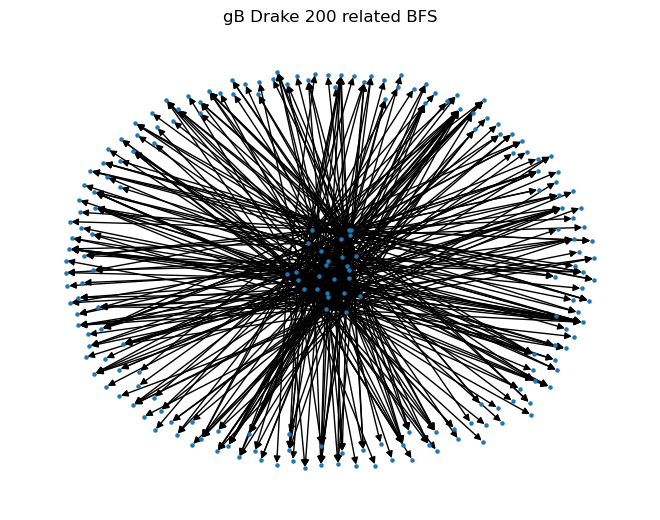

order: 205  size: 540
indegree: median[2.0], max[13],  min[0]
outdegree: median[0.0], max[20],  min[0]
(b) A graph of related artists starting with the artist Drake and exploring 200 artists with DFS (we will call this graph gD).


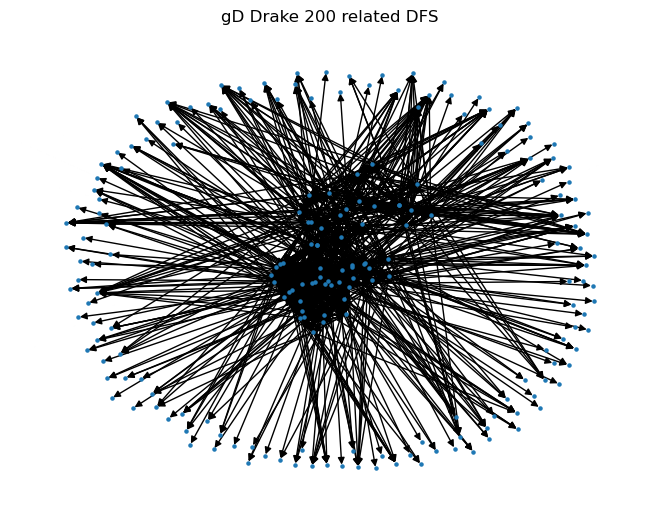

order: 201  size: 1200
indegree: median[3.0], max[28],  min[0]
outdegree: median[0.0], max[20],  min[0]
(c) A dataset of songs from all the explored artists that appear in any of the previous graphs (we will call this dataset D).
                Artist               Artist_id  \
0                Drake  3TVXtAsR1Inumwj472S9r4   
1                Drake  3TVXtAsR1Inumwj472S9r4   
2                Drake  3TVXtAsR1Inumwj472S9r4   
3                Drake  3TVXtAsR1Inumwj472S9r4   
4                Drake  3TVXtAsR1Inumwj472S9r4   
...                ...                     ...   
4047  Criminal Elament  1zT1cW7yHZo4jUwGIy8Z6P   
4048  Criminal Elament  1zT1cW7yHZo4jUwGIy8Z6P   
4049  Criminal Elament  1zT1cW7yHZo4jUwGIy8Z6P   
4050  Criminal Elament  1zT1cW7yHZo4jUwGIy8Z6P   
4051  Criminal Elament  1zT1cW7yHZo4jUwGIy8Z6P   

                           Track Name                Track ID  Duration  \
0                     Search & Rescue  7aRCf5cLOFN1U7kvtChY1G    272112   
1                  

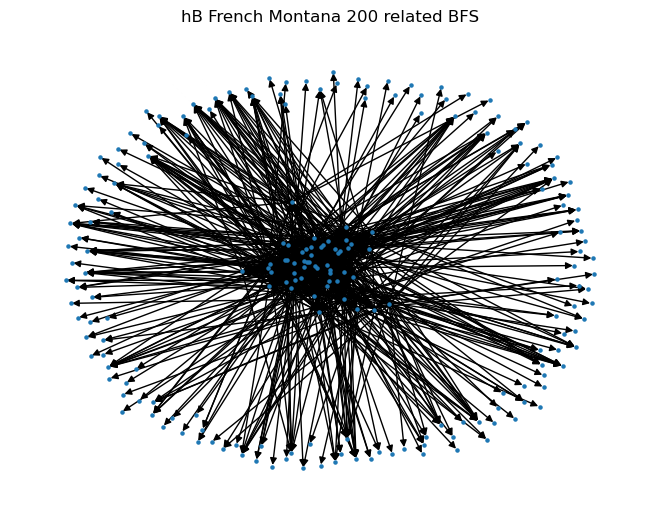

order: 207  size: 1060
indegree: median[2.0], max[31],  min[1]
outdegree: median[0.0], max[20],  min[0]
(e) A graph of related artists starting with the last crawled artist from gD and exploring 200 artists with BFS (we will call this graph fB).


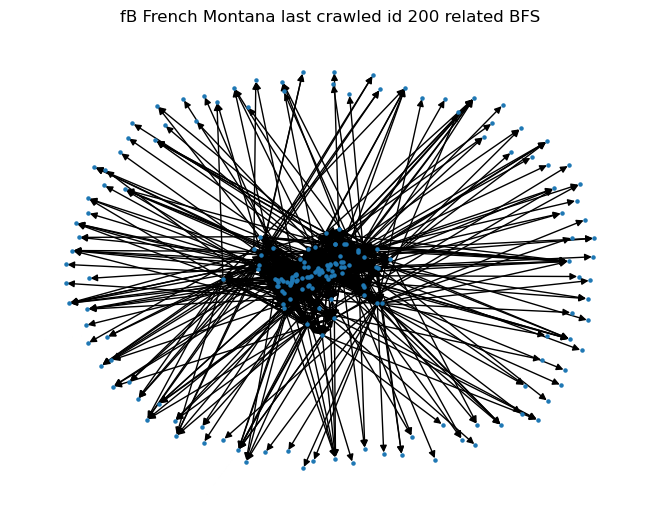

order: 200  size: 1880
indegree: median[4.5], max[49],  min[1]
outdegree: median[0.0], max[20],  min[0]


In [2]:
import networkx as nx
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import numpy as np
import time

# ------- IMPLEMENT HERE ANY AUXILIARY FUNCTIONS NEEDED ------- #
def print_graf_measures(g):
    indegrees = [d for id,d in g.in_degree()]
    outdegrees = [d for id,d in g.out_degree()]

    print(f"order: {g.order()}  size: {g.size()}")
    print(f"indegree: median[{np.median(indegrees)}], max[{np.max(indegrees)}],  min[{np.min(indegrees)}]")
    print(f"outdegree: median[{np.median(outdegrees)}], max[{np.max(outdegrees)}],  min[{np.min(outdegrees)}]")
# --------------- END OF AUXILIARY FUNCTIONS ------------------ #


def search_artist(artist_name: str) -> str:
    """
    Search for an artist in Spotify.

    :param artist_name: name to search for.
    :return: spotify artist id.
    """
    # ------- IMPLEMENT HERE THE BODY OF THE FUNCTION ------- #
    return sp.search(artist_name,type="artist",limit=1)["artists"]["items"][0]["id"]
    # ----------------- END OF FUNCTION --------------------- #


def crawler(seed: str, max_nodes_to_crawl: int, strategy: str = "BFS", out_filename: str = "g.graphml",return_last_cr = False) -> nx.DiGraph:
    """
    Crawl the Spotify artist graph, following related artists.

    :param seed: starting artist id.
    :param max_nodes_to_crawl: maximum number of nodes to crawl.
    :param strategy: BFS or DFS.
    :param out_filename: name of the graphml output file.
    :return: networkx directed graph.
    """
    # ------- IMPLEMENT HERE THE BODY OF THE FUNCTION ------- #
    G=nx.DiGraph()
    
    current_seed = seed
    crawled = [] 
    tocrawl = []
    tocrawl_aux = []
    
    #cnt = 0
    while len(G.nodes()) < max_nodes_to_crawl:
        #cnt += 1
        #sleep one second to be polite to the spotify API.
        time.sleep(1)
        #print(tocrawl_aux)
        
        #first crawl
        #print("Crawling: ",current_seed)
        found = sp.artist_related_artists(current_seed)
        crawled.append(current_seed)
        found_ids = [art["id"] for art in found["artists"]] #get found artists ids
        #not_crawled = [id for id in found_ids if id not in crawled]
        #Add edges to graph:
        node_pairs = [(current_seed,id) for id in found_ids]  #create node pairs with current crawled node
        G.add_edges_from(node_pairs) #add found edges and new nodes to graph
        
        if strategy == "BFS":
            tocrawl = tocrawl + found_ids #add new nodes to tocrawl pile mantaining BFS priority
            #tocrawl_aux += [cnt]*len(not_crawled)
            
        elif strategy == "DFS":            
            tocrawl = found_ids + tocrawl #add new nodes to tocrawl pile mantaining DFS priority
            #tocrawl_aux  = [cnt]*len(not_crawled) + tocrawl_aux

        current_seed = tocrawl[0]
        tocrawl = tocrawl[1:]
        #tocrawl_aux.remove(tocrawl_aux[0])
        while current_seed in crawled: #in case the node we are about to crawl has aleady been crawled
            #print("Node already crawled, next...")
            current_seed = tocrawl[0]
            tocrawl = tocrawl[1:]
            #tocrawl_aux.remove(tocrawl_aux[0])
    
    #save graph to file
    nx.write_graphml(G,out_filename)
    
    #depending on the output mode
    if return_last_cr:
        return G, crawled[-1]
    
    return G

    # ----------------- END OF FUNCTION --------------------- #


def get_track_data(graphs: list, out_filename: str) -> pd.DataFrame:

    """
    Get track data for each visited artist in the graph.

    :param graphs: a list of graphs with artists as nodes.
    :param out_filename: name of the csv output file.
    :return: pandas dataframe with track data.
    
    """
    data = []
    seen_artist_ids = set()
    for graph in graphs:
        for artist_id,out_degree in graph.out_degree():

            #to not to repeat artists we check if we have already seen it
            #also check if the artist was discovered or crawled. If wasn't crawled oud_degree <1 then just ignore it
            if artist_id  in seen_artist_ids and out_degree<1:
                continue #go to next id
            
            artist = sp.artist(artist_id)
            #artist_id = search_artist(artist)
            top_tracks = sp.artist_top_tracks(artist_id,country='ES')


            for track in  top_tracks["tracks"]:
                track_info = sp.audio_features(track["id"])
                data.append({
                            
                        #Artist data
                            
                        "Artist": artist["name"],
                        "Artist_id" : artist_id,

                        #Basic Song Data

                        "Track Name": track["name"],
                        "Track ID": track["id"],
                        "Duration" :track["duration_ms"],
                        "Popularity": track["popularity"],

                        # Audio feature data for the song
                        "Danceablility": track_info[0]['danceability'],
                        "Energy": track_info[0]['energy'],
                        "Loudness": track_info[0]['loudness'],
                        "Speechiness": track_info[0]['speechiness'],
                        "Acoustincness": track_info[0]['acousticness'],
                        "Instrumentalness": track_info[0]['instrumentalness'],
                        "Liveness": track_info[0]['liveness'],
                        "Valence": track_info[0]['valence'],
                        "Tempo": track_info[0]['tempo'],

                        # Album data
                        "Album Name": track["album"]["name"],
                        "Album ID": track["album"]["id"],
                        "Album release date": track["album"]["release_date"]

                })
        

    df = pd.DataFrame(data)
    df.to_csv(out_filename, index=False) #df to csv
    
    return df


if __name__ == "__main__":
    # ------- IMPLEMENT HERE THE MAIN FOR THIS SESSION ------- #
    CLIENT_ID = "d010f6f0d59d48f6ac33d44e235ac008"
    CLIENT_SECRET = "08b56260df6d41ec8ee872a39997fc97"
    auth_manager = SpotifyClientCredentials(
    client_id=CLIENT_ID ,
    client_secret=CLIENT_SECRET)
    sp = spotipy.Spotify(auth_manager=auth_manager)

    print("4. (1 point) Using the previous functions, obtain:")
    print("(a) A graph of related artists starting with the artist Drake and exploring 200 artists with BFS (we will call this graph gB).")
    id = search_artist("Drake")
    gB = crawler(id, max_nodes_to_crawl=200, strategy= "BFS", out_filename= "g_gB.graphml")
    nx.draw(gB, with_labels=False,node_size=5)
    plt.title("gB Drake 200 related BFS")
    plt.show()
    print_graf_measures(gB)

    print("(b) A graph of related artists starting with the artist Drake and exploring 200 artists with DFS (we will call this graph gD).")
    id = search_artist("Drake")
    gD = crawler(id, max_nodes_to_crawl=200, strategy= "DFS", out_filename= "g_gD.graphml")
    nx.draw(gD, with_labels=False,node_size=5)
    plt.title("gD Drake 200 related DFS")
    plt.show()
    print_graf_measures(gD)

    print("(c) A dataset of songs from all the explored artists that appear in any of the previous graphs (we will call this dataset D).")
    D = get_track_data([gB,gD], "D.csv")
    print(D)

    print("(d) A graph of related artists starting with the artist French Montana and exploring 200 artists with BFS (we will call this graph hB).")
    id = search_artist("French Montana")
    hB, last_cralwed = crawler(id, max_nodes_to_crawl=200, strategy= "BFS", out_filename= "g_hB.graphml",return_last_cr=True)
    nx.draw(hB, with_labels=False,node_size=5)
    plt.title("hB French Montana 200 related BFS")
    plt.show()
    print_graf_measures(hB)
    
    print("(e) A graph of related artists starting with the last crawled artist from gD and exploring 200 artists with BFS (we will call this graph fB).")
    fB, last_cralwed = crawler(last_cralwed, max_nodes_to_crawl=200, strategy= "BFS", out_filename= "g_fB.graphml",return_last_cr=True)
    nx.draw(fB, with_labels=False,node_size=5)
    plt.title("fB French Montana last crawled id 200 related BFS")
    plt.show()
    print_graf_measures(fB)

    pass
    # ------------------- END OF MAIN ------------------------ #